<a href="https://colab.research.google.com/github/Bziukiewicz/tests/blob/master/arrythmia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analiza danych EKG, prognozowanie zaburzeń z użyciem modeli uczenia maszynowego, oraz uczenia głębokiego

## 1. Instalacja, oraz import bibliotek

In [ ]:
pip install keras

In [ ]:
pip install tensorflow

In [ ]:
pip install mlxtend

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
import tensorflow as tf

## 2. Wczytanie, oraz przygotowanie danych

In [7]:
train_df= pd.read_csv('/content/drive/MyDrive/mitbih_train.csv')

In [8]:
test_df= pd.read_csv('/content/drive/MyDrive/mitbih_test.csv')

In [9]:
train_df.columns= list(range(len(train_df.columns)))
test_df.columns= list(range(len(test_df.columns)))

In [10]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87548,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87549,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [11]:
train_df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

In [12]:
train_df[187].value_counts()

187
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

In [13]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87553 entries, 0 to 87552
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [14]:
import plotly.express as px
counts = train_df[187].value_counts()

bar_width = 0.4

x_values = np.arange(len(counts.index))

fig = px.bar(x=x_values, y=counts.values, labels={'x': 'Wartość', 'y': 'Liczba wystąpień'})

fig.update_xaxes(tickvals=x_values, ticktext=counts.index)

fig.update_layout(title='Rozklład zdiagnozowanych chorób',
                  xaxis_title='Typy Chorób',
                  yaxis_title='Liczba wystąpień')

fig.show()

### Ze względu na dużą ilość próbek klasy 0, zmniejszamy ilosc probek w tej klasie, aby uniknąć przeuczenia modeli

In [15]:
from sklearn.utils import resample

df_0 = train_df[train_df[187]==0].sample(n =20000, random_state=42)
df_1 = train_df[train_df[187] == 1]
df_2 = train_df[train_df[187] == 2]
df_3 = train_df[train_df[187] == 3]
df_4 = train_df[train_df[187] == 4]
train_df = pd.concat([df_0, df_1, df_2, df_3, df_4])

In [16]:
counts = train_df[187].value_counts()

bar_width = 0.4

x_values = np.arange(len(counts.index))

fig = px.bar(x=x_values, y=counts.values, labels={'x': 'Wartość', 'y': 'Liczba wystąpień'})

fig.update_xaxes(tickvals=x_values, ticktext=counts.index)

fig.update_layout(title='Rozkład zdiagnozowanych chorób',
                  xaxis_title='Typy chorób',
                  yaxis_title='Liczba wystąpień')

fig.show()

### Na podstawie wykresów z pięciu pierwszych próbek możemy zauważyć podobieństwa wyników EKG w kazdej klasie

In [17]:
class_names = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
k = 5
samples = [train_df.loc[train_df[187] == cls].sample(k) for cls in range(k)]
titles = [class_names[cls] for cls in range(5)]

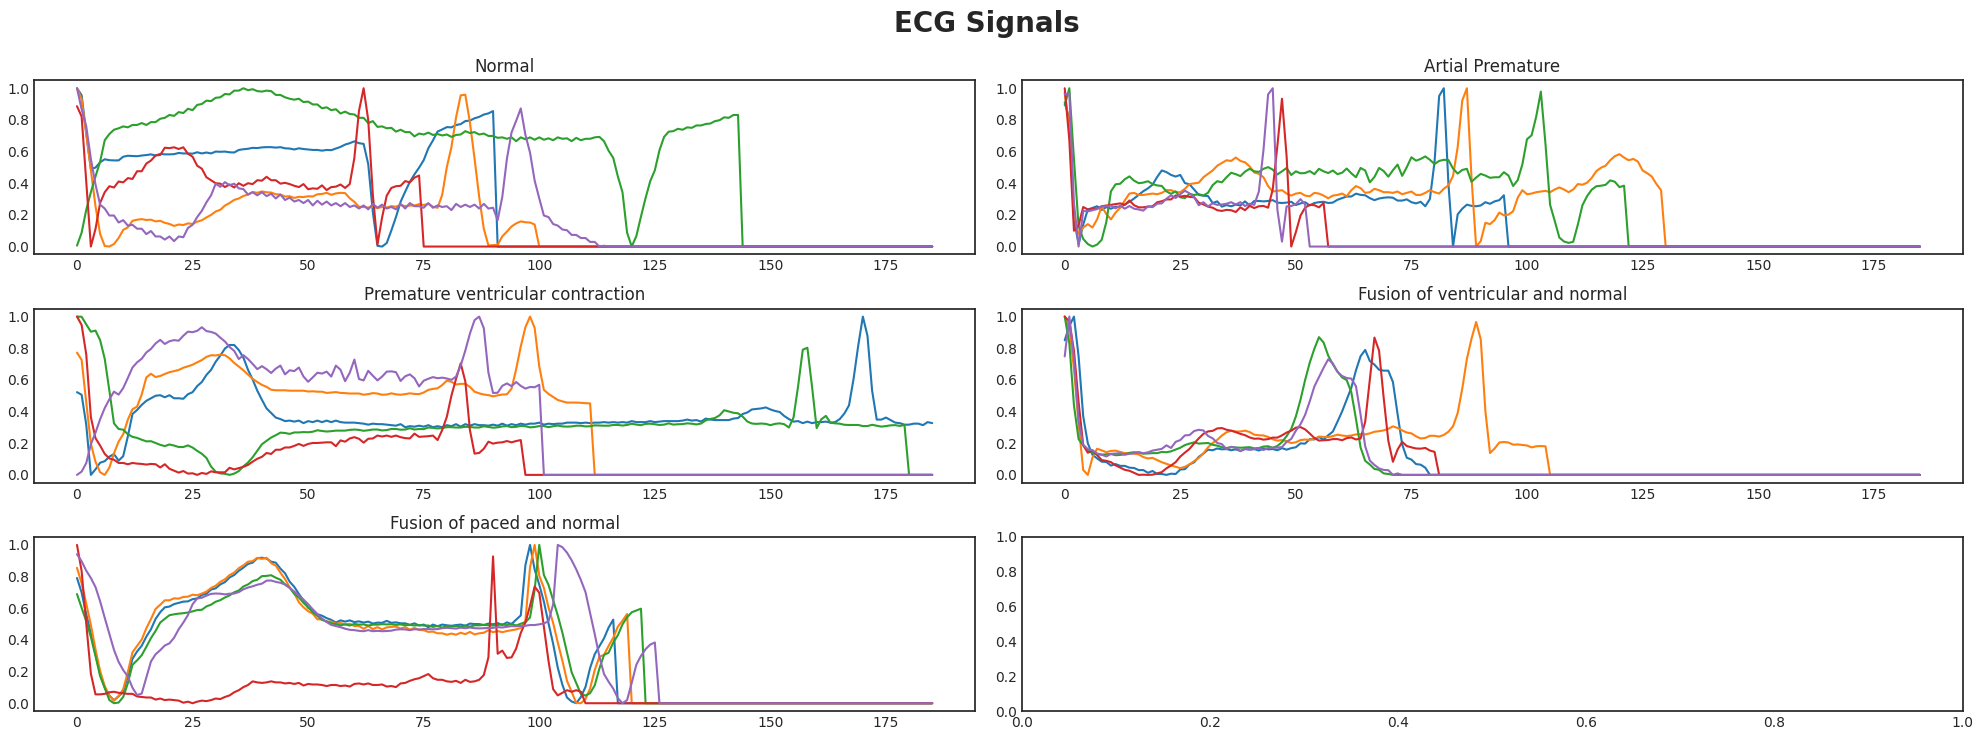

In [18]:
with plt.style.context("seaborn-white"):
    fig, axs = plt.subplots(3, 2, figsize=(20, 7))
    for i in range(5):
        ax = axs.flat[i]
        ax.plot(samples[i].values[:,:-2].transpose())
        ax.set_title(titles[i])
        #plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.suptitle("ECG Signals", fontsize=20, y=1.05, weight="bold")
    plt.savefig(f"signals_per_class.svg",
                    format="svg",bbox_inches='tight', pad_inches=0.2)

    plt.savefig(f"signals_per_class.png",
                    format="png",bbox_inches='tight', pad_inches=0.2)

In [19]:
X_train = train_df.copy()
y_train = X_train.pop(187)
X_test = train_df.copy()
y_test = X_test.pop(187)

### Za pomocą dunkcji z boblioteki scipy usuwamy zaszumienie danych treningowych

In [20]:

from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Funkcja do filtracji danych
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

cutoff_freq = 50.0
sampling_freq = 1000.0
order = 6


ekg_data = X_train


filtered_data = butter_lowpass_filter(ekg_data, 50, 125)


In [21]:
filtered_data= pd.DataFrame(filtered_data)
filtered_data

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.923373,0.806926,0.375958,0.013583,0.009498,0.091545,0.134451,0.179614,0.179764,0.182645,...,1.211340e-08,2.925577e-09,-1.239568e-08,1.494639e-08,-1.187902e-08,5.911366e-09,1.355943e-10,-4.280951e-09,5.766088e-09,-4.925023e-09
1,1.000024,0.767242,0.228982,0.061304,0.156746,0.134667,0.128298,0.125391,0.101814,0.119122,...,2.543835e-11,-5.445263e-11,5.694249e-11,-4.025267e-11,1.567110e-11,6.429966e-12,-1.966375e-11,2.246836e-11,-1.713090e-11,7.869591e-12
2,0.999987,0.843586,0.368154,0.108843,0.166593,0.182408,0.166066,0.182100,0.183073,0.174910,...,2.015165e-09,-1.140299e-10,-1.239563e-09,1.776249e-09,-1.573514e-09,9.240824e-10,-1.752027e-10,-4.003080e-10,6.693674e-10,-6.387713e-10
3,0.978434,0.728471,0.517854,0.308416,0.212227,0.162888,0.091839,0.086758,0.087991,0.075135,...,1.447495e-10,-5.032399e-10,5.888245e-10,-4.576858e-10,2.188015e-10,1.748994e-11,-1.755563e-10,2.282491e-10,-1.907970e-10,1.029038e-10
4,0.868362,0.673509,0.379431,0.103679,0.012652,0.090859,0.146771,0.121744,0.106964,0.109741,...,-1.378835e-11,1.215053e-11,-7.087711e-12,1.288973e-12,3.145029e-12,-5.200007e-12,4.941923e-12,-3.163833e-12,9.065416e-13,9.533215e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35078,0.807082,0.499826,0.528143,0.539610,0.482999,0.488895,0.455913,0.392449,0.291510,0.127703,...,-5.518251e-08,4.642929e-08,-2.535547e-08,2.559462e-09,1.406037e-08,-2.102811e-08,1.905438e-08,-1.152068e-08,2.567245e-09,4.476047e-09
35079,0.718302,0.604976,0.486591,0.362100,0.230622,0.121805,0.049124,0.004747,-0.003292,0.016451,...,-8.570346e-07,1.072857e-07,4.466771e-07,-6.859209e-07,6.297974e-07,-3.871998e-07,9.386613e-08,1.397275e-07,-2.563090e-07,2.539955e-07
35080,0.906064,0.627238,0.590993,0.581786,0.523856,0.488151,0.439125,0.392437,0.319100,0.193713,...,-1.445355e-06,1.252609e-06,-7.141249e-07,1.102154e-07,3.437930e-07,-5.471671e-07,5.111001e-07,-3.207124e-07,8.486461e-08,1.062614e-07
35081,0.858234,0.685234,0.776596,0.329304,0.091752,0.187427,0.091387,0.127708,0.129496,0.085948,...,-2.251589e-07,1.880378e-07,-1.015321e-07,8.781352e-09,5.831218e-08,-8.593893e-08,7.728404e-08,-4.627758e-08,9.796718e-09,1.868592e-08


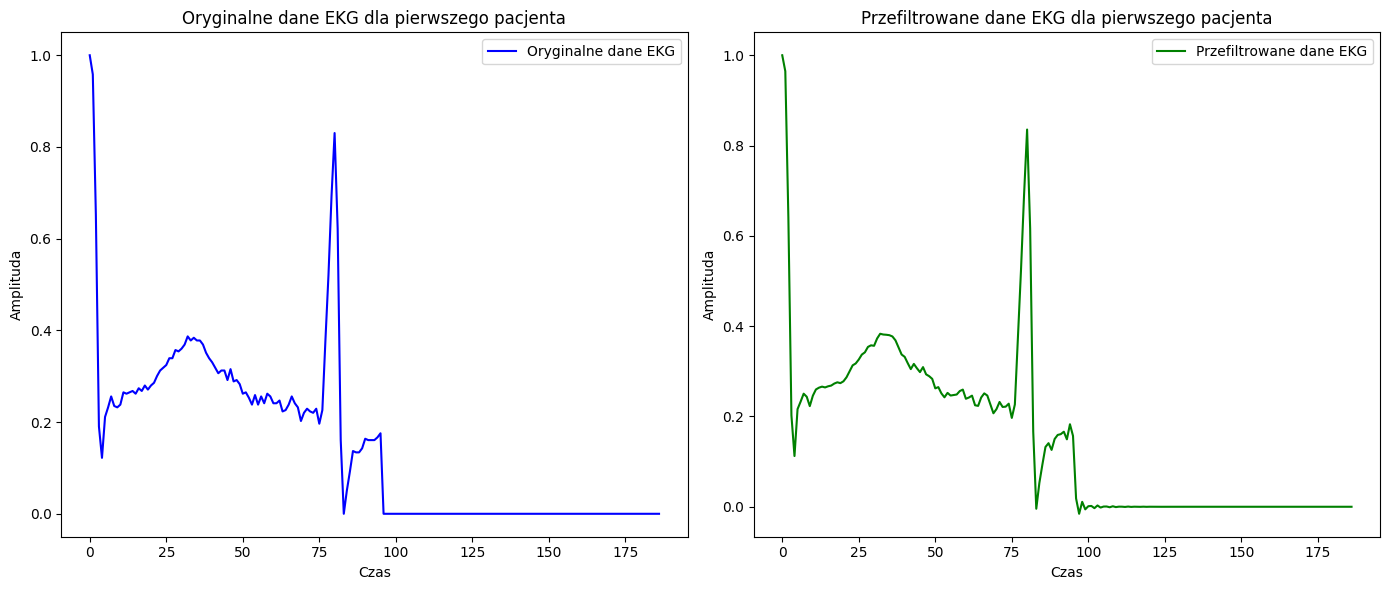

In [22]:
import matplotlib.pyplot as plt


index = 5

original_data_row = ekg_data.iloc[index]
filtered_data_row = filtered_data.iloc[index]

plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.plot(original_data_row, label='Oryginalne dane EKG', color='blue')
plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title('Oryginalne dane EKG dla pierwszego pacjenta')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(filtered_data_row, label='Przefiltrowane dane EKG', color='green')
plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title('Przefiltrowane dane EKG dla pierwszego pacjenta')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [24]:
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)

In [25]:
X_train.shape

(35083, 187)

# Modele uczenia maszynowego

## 1. Regresja logistyczna

In [26]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(max_iter=20000)
logistic_regression.fit(X_train, y_train)

LogisticRegression(max_iter=20000)

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix

y_pred = logistic_regression.predict(X_test)
accuracy_score(y_test, y_pred)

0.8403785309124078

In [28]:
cm = confusion_matrix(y_test, y_pred)
import plotly.figure_factory as ff
def plot_confusion_matrix(cm):
    fig = ff.create_annotated_heatmap(z=cm, x=[f'pred_{i}' for i in range(5)], y=[f'true_{i}' for i in range(5)],
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_yaxes(categoryorder='array', categoryarray=[f'true_{i}' for i in range(4, -1, -1)])
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88     20000
         1.0       0.86      0.56      0.68      2223
         2.0       0.71      0.62      0.66      5788
         3.0       0.63      0.44      0.52       641
         4.0       0.95      0.91      0.93      6431

    accuracy                           0.84     35083
   macro avg       0.80      0.69      0.73     35083
weighted avg       0.84      0.84      0.83     35083



##  2. Lasy losowe

In [30]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [31]:
y_pred = random_forest.predict(X_test)

accuracy_score(y_test, y_pred)

1.0

In [32]:
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm):
    fig = ff.create_annotated_heatmap(z=cm, x=[f'pred_{i}' for i in range(5)], y=[f'true_{i}' for i in range(5)],
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_yaxes(categoryorder='array', categoryarray=[f'true_{i}' for i in range(4, -1, -1)])
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20000
         1.0       1.00      1.00      1.00      2223
         2.0       1.00      1.00      1.00      5788
         3.0       1.00      1.00      1.00       641
         4.0       1.00      1.00      1.00      6431

    accuracy                           1.00     35083
   macro avg       1.00      1.00      1.00     35083
weighted avg       1.00      1.00      1.00     35083



## 3. K-najbliższych sąsiadów

In [34]:
from sklearn.neighbors import KNeighborsClassifier

KNeighbors = KNeighborsClassifier(n_neighbors=5)
KNeighbors.fit(X_train, y_train)
y_pred = KNeighbors.predict(X_test)
accuracy_score(y_test, y_pred)

0.9596670752216173

In [35]:
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm):
    fig = ff.create_annotated_heatmap(z=cm, x=[f'pred_{i}' for i in range(5)], y=[f'true_{i}' for i in range(5)],
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_yaxes(categoryorder='array', categoryarray=[f'true_{i}' for i in range(4, -1, -1)])
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     20000
         1.0       0.93      0.78      0.85      2223
         2.0       0.95      0.94      0.95      5788
         3.0       0.89      0.77      0.83       641
         4.0       0.99      0.98      0.99      6431

    accuracy                           0.96     35083
   macro avg       0.95      0.89      0.92     35083
weighted avg       0.96      0.96      0.96     35083



## 2. Maszyny wektorów nośnych

In [37]:
from sklearn.svm import SVC

svc = SVC(C=1.0, kernel='rbf', random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.9436194168115611

In [38]:
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm):
    fig = ff.create_annotated_heatmap(z=cm, x=[f'pred_{i}' for i in range(5)], y=[f'true_{i}' for i in range(5)],
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_yaxes(categoryorder='array', categoryarray=[f'true_{i}' for i in range(4, -1, -1)])
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     20000
         1.0       0.97      0.66      0.79      2223
         2.0       0.96      0.92      0.94      5788
         3.0       0.87      0.60      0.71       641
         4.0       0.99      0.95      0.97      6431

    accuracy                           0.94     35083
   macro avg       0.94      0.82      0.87     35083
weighted avg       0.94      0.94      0.94     35083



#  Modele uczenia głębokiego

## 1. RNN- Rekurencyjna sieć neuronowa


In [40]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, Lambda, GRU, LSTM, GlobalMaxPooling1D

rnn_model = Sequential()


rnn_model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=(187,)))
rnn_model.add(LSTM(64, input_shape=(187, ), return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(64))
rnn_model.add(Dense(128, activation='relu'))
rnn_model.add(Dropout(0.1))
rnn_model.add(Dense(5, activation='softmax'))


rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


rnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 187, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 187, 64)           16896     
                                                                 
 dropout (Dropout)           (None, 187, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

In [42]:
history = rnn_model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=128, callbacks=[es])

Epoch 1/100
220/220 [==============================] - 147s 646ms/step - loss: 0.8129 - accuracy: 0.7190 - val_loss: 7.7388 - val_accuracy: 0.0000e+00
Epoch 2/100
220/220 [==============================] - 140s 635ms/step - loss: 0.7498 - accuracy: 0.7209 - val_loss: 8.2887 - val_accuracy: 0.0000e+00
Epoch 3/100
220/220 [==============================] - 142s 646ms/step - loss: 0.7570 - accuracy: 0.7227 - val_loss: 8.0302 - val_accuracy: 0.0000e+00
Epoch 4/100
220/220 [==============================] - 153s 695ms/step - loss: 0.7444 - accuracy: 0.7308 - val_loss: 8.8557 - val_accuracy: 0.0000e+00
Epoch 5/100
220/220 [==============================] - 145s 662ms/step - loss: 0.7541 - accuracy: 0.7278 - val_loss: 8.7367 - val_accuracy: 0.0000e+00
Epoch 6/100
220/220 [==============================] - 153s 695ms/step - loss: 0.7614 - accuracy: 0.7214 - val_loss: 9.8177 - val_accuracy: 0.0000e+00
Epoch 7/100
220/220 [==============================] - 142s 646ms/step - loss: 0.7432 - accura

In [ ]:
rnn2_model = Sequential()
rnn2_model.add(Input(shape=[len(X_train.keys())]))
rnn2_model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1)))
rnn2_model.add(GRU(128, return_sequences=True))
rnn2_model.add(Flatten())
rnn2_model.add(Dense(5, activation='softmax'))

rnn2_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rnn2_model.summary()

In [ ]:
history = rnn2_model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=128, callbacks=[es])

In [ ]:
test_results = rnn_model.evaluate(X_test, y_test, verbose=0)
print(test_results)

In [ ]:

predicted_probabilities = rnn_model.predict(X_test)


predicted_classes = np.argmax(predicted_probabilities, axis=1)

print(predicted_classes)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

## 2. CNN- Konwolucyjne sieci neuronowe

In [48]:
cnn_model = Sequential()